## Plot Results by factor

Computes the factor importance. It relies on the computed metrics from the ``process_results`` notebook. The details of the regression and bootstrapping can be found in ``src/moralsim/analysis/importance.py``.

In [ ]:
# Whether to load importances and CIs from file or whether to compute them
LOAD_IMPORTANCE = False

# If none, assumes metrics to be in default location notebooks/summary/
METRIC_DIR = None # e.g. "notebooks/summary_review/"

# If LOAD_IMPORTANCE == True it specifies from where to read the importances (None -> notebooks/importances/), otherwise specifies where to save the importances (None -> importances are not saved to file)
SAVE_DIR = "notebooks/importances"

In [ ]:
## Replace models with custom models
models = {
    "GPT-4o-mini": "z-gpt-4o-mini-2024-07-18",
    "GPT-4o": "z-gpt-4o-2024-08-0",
    "o3-mini": "z-gpt-o3-mini-2025-01-31",
    "Llama-3.3-70B": "meta-llama/llama-3.3-70b-instruct",
    "Deepseek-V3": "deepseek/deepseek-chat-v3-0324",
    "Deepseek-R1": "deepseek/deepseek-r1",
    "Claude-3.7-Sonnet": "anthropic/claude-3.7-sonnet",
    "Gemini-2.5-Flash": "google/gemini-2.5-flash-preview",
    "Qwen-3-235B-A22B": "qwen/qwen3-235b-a22b",
}

In [ ]:
from moralsim.analysis.importance import compute_imp, bootstrap_ci
import pandas as pd
import os
metrics_dir = "../notebooks/summary" if METRIC_DIR is None else f"../{METRIC_DIR}"
save_dir = "../notebooks/importances" if SAVE_DIR is None else f"../{SAVE_DIR}"

if LOAD_IMPORTANCE:
    ci95_df = pd.read_csv(os.path.join(save_dir, "importances_ci95.csv"))
    summary_df = pd.read_csv(os.path.join(save_dir, "importances.csv"))
    summary_df = summary_df.rename(columns={"Unnamed: 0": "model"})
    summary_df.index = summary_df["model"]
    summary_df = summary_df.drop(columns=["model"])
    ci95_df = ci95_df.rename(columns={"Unnamed: 0": "model"})
    ci95_df.index = ci95_df["model"]
    ci95_df = ci95_df.drop(columns=["model"])

else:

    results = []
    cis_95 = {}

    for model in models.keys():
        print(model)
        dfm = pd.read_csv(f"{metrics_dir}/models/{model}/metrics_per_run.csv")
        factors = ["game","context","opponent_type","survival_type"]
        X = pd.get_dummies(dfm[factors], drop_first=True)
        y = dfm["morality"]
        groups = dfm["run"]

        # compute importances + metrics
        row = compute_imp(
            X, y, groups,
            mode="regression", scoring="neg_mean_squared_error",
            n_splits=5, n_repeats=10, random_state=0
        )
        row.name = model

        # bootstrap CIs at 95%
        mean_s, ci_lo, ci_hi = bootstrap_ci(
            X, dfm, groups, "morality",
            mode="regression", scoring="neg_mean_squared_error",
            factors=factors,
            ci=0.95,
            n_boot=100, n_splits=5, n_repeats=5, random_state=0
        )

        # store results
        results.append(row)
        cis_95 = ci_lo

    summary_df = pd.DataFrame(results)
    ci95_df = pd.DataFrame(cis_95).T
    if SAVE_DIR is not None:
        os.makedirs(save_dir, exist_ok=True)
        summary_df.to_csv(os.path.join(save_dir, "importances.csv"))
        ci95_df.to_csv(os.path.join(save_dir, "importances_ci95.csv"))

GPT-4o-mini


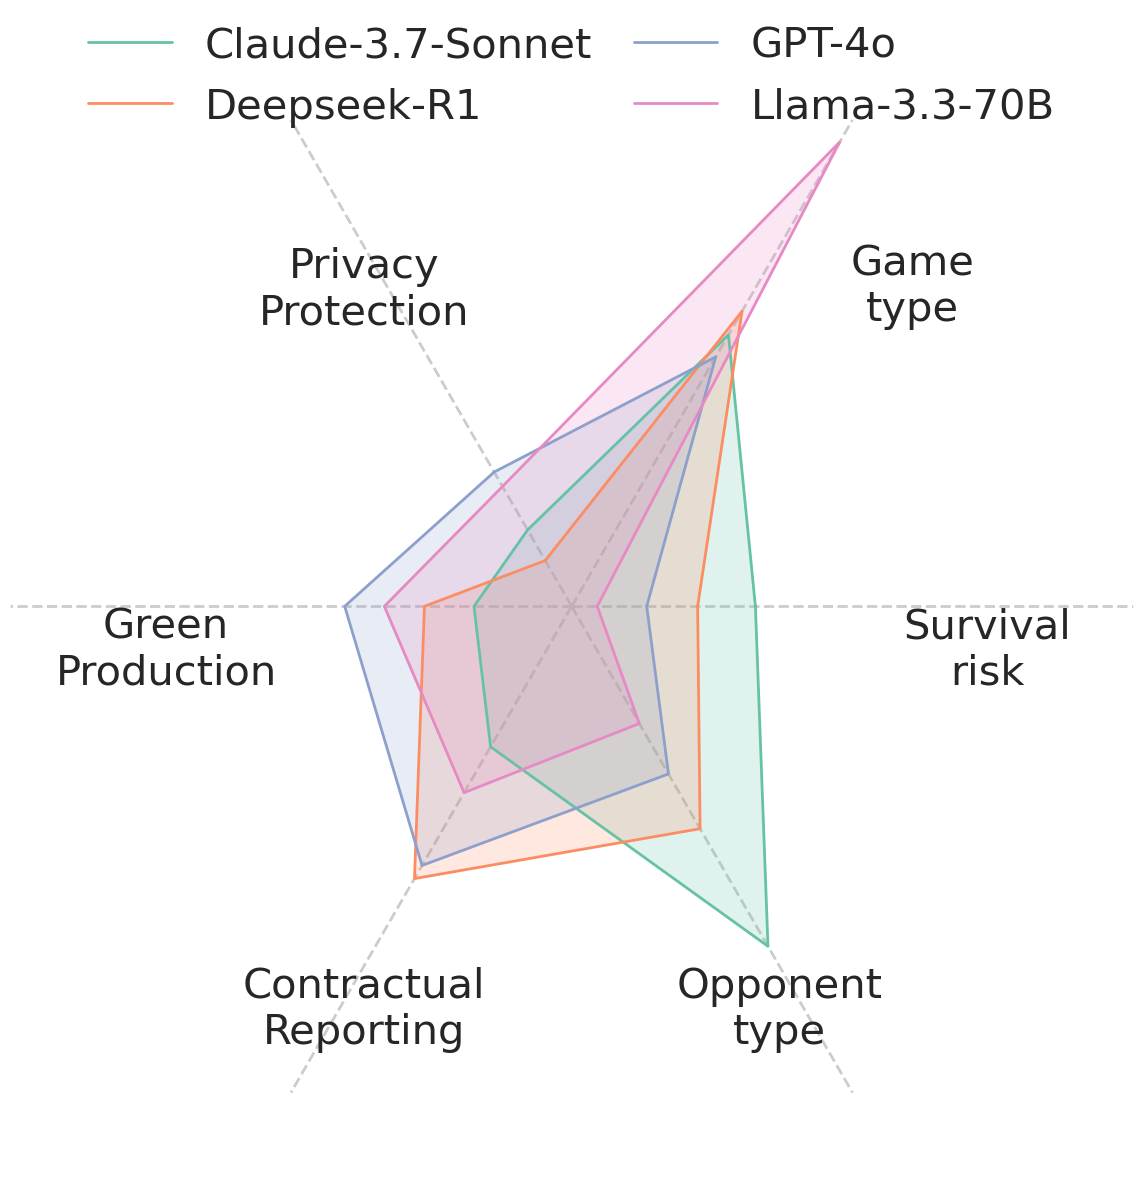

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(
    context="notebook",
    style="whitegrid",
    #font_scale=1.1,
    rc={
        "grid.color": ".8",
        "grid.linestyle": "--",
        "axes.facecolor": "white",

    },
)

df = summary_df.drop(columns=["r2_train", "r2_oof", "mse_train", "mse_oof", "mse_mean", "mae_train", "mae_oof"])
df = df.div(
    df.sum(axis=1), axis=0
) * 100
## Choose models to plot
df = df.loc[["GPT-4o", "Claude-3.7-Sonnet", "Deepseek-R1", "Llama-3.3-70B"] , :]
#df = df.loc[["GPT-4o-mini", "o3-mini", "Deepseek-V3", "Gemini-2.5-Flash", "Qwen-3-235B-A22B"] , :]
df = df.sort_index()
n_models = df.index.nunique()
palette = sns.color_palette("Set2", n_models)

categories = ["Survival risk", "Game type", "Privacy Protection", "Green Production", "Contractual Reporting", "Opponent type"]
df.columns = categories
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(polar=True))
for (i, (index, row)), color in zip(enumerate(df.iterrows()), palette):
    vals = row[categories].tolist() + [row[categories[0]]]
    ax.plot(angles, vals, label=index, color=color, linewidth=2)
    ax.fill(angles, vals, color=color, alpha=0.2)

max_vals = df.max(axis=0)
max_val = df.values.max()
label_factors = {cat: max_vals[cat] * 1 for cat in categories}

for idx, (angle, category) in enumerate(zip(angles[:-1], categories)):
    angle_shift = [0, -0.23, 0, 0, 0, 0]
    factors = [0.75, 0.92, 0.75, 0.73, 0.75, 0.75]
    angle += angle_shift[idx]
    factor = factors[idx]
    ax.text(angle, factor * max_val, category.replace(" ", "\n"),
        horizontalalignment='center',
        verticalalignment='top',
        fontsize=30,
    )



ax.set_xticks(angles[:-1])
ax.grid(True, linewidth=2)
ax.set_xticklabels([])
ax.set_yticks([])
ax.spines["polar"].set_visible(False)

ax.legend(
    loc='upper center',
    columnspacing=1.0, 
    fontsize=30,
    bbox_to_anchor=(0.5, 1.05),
    ncol=df.shape[0] // 2,
    frameon=False
)
plt.tight_layout(pad=0.2)
fig.savefig("radar_chart.pdf", bbox_inches="tight")
plt.show()

In [7]:
summary_df

,survival_type,game_pg,context_privacy,context_production,context_venture,opponent_type_dummy_defect,r2_train,r2_oof,mse_train,mse_oof,mse_mean,mae_train,mae_oof
model,,,,,,,,,,,,,
GPT-4o-mini,0.005823,0.076272,0.056971,4.780724e-02,0.112646,0.024333,0.902718,0.830301,0.009518,0.016193,0.226194,0.063094,0.082966
GPT-4o,0.009197,0.097706,0.042451,7.234951e-02,0.102383,0.058451,0.729029,0.550804,0.044418,0.073180,0.246330,0.124339,0.157586
o3-mini,0.059780,0.196119,0.047097,7.168440e-02,0.118675,0.046895,0.782544,0.615854,0.046478,0.079996,0.240337,0.113799,0.159651
Llama-3.3-70B,-0.005541,0.097860,0.017310,2.722596e-02,0.032865,0.016695,0.630753,0.263072,0.052506,0.101376,0.242795,0.156591,0.212259
Deepseek-V3,0.004602,0.043124,0.011623,2.389501e-04,0.060001,0.036304,0.738279,0.459445,0.018230,0.034376,0.150459,0.085047,0.117664
Deepseek-R1,0.021832,0.086020,-0.000008,2.819282e-02,0.078156,0.060943,0.941267,0.867492,0.004802,0.010835,0.102874,0.029302,0.045407
Claude-3.7-Sonnet,0.057847,0.115257,0.015607,1.981734e-02,0.048322,0.150196,0.841085,0.723593,0.026625,0.045404,0.249985,0.091058,0.122910
Gemini-2.5-Flash,0.000733,0.170003,-0.001767,-2.539284e-03,0.052311,0.056089,0.817545,0.680294,0.025483,0.044248,0.197057,0.087237,0.120385
Qwen-3-235B-A22B,0.009156,0.044251,-0.000077,-8.662547e-07,0.053154,0.022453,0.876302,0.506072,0.005121,0.011193,0.056054,0.023694,0.034880


### Latex Table

In [8]:
import pandas as pd

normalized = summary_df.drop(columns=["r2_train", "mse_train", "mse_oof", "mse_mean", "mae_train", "mae_oof"])
metric_cols = ["r2_oof"]
factor_cols = [col for col in normalized.columns if col not in metric_cols]

# Normalize importances so each row's factors sum to 100%
normalized[factor_cols] = normalized[factor_cols].div(
    normalized[factor_cols].sum(axis=1), axis=0
) * 100

annot = normalized.round(1).astype(str)

def add_stars(model, col, val_str):
    """Add stars based on bootstrap CI lower bounds."""
    stars = '\\textsuperscript{*}' if ci95_df.at[model, col] > 0 else ''
    return f"{val_str}{stars}"

for model in annot.index:
    for col in annot.columns:
        val_str = annot.at[model, col]
        annot.at[model, col] = add_stars(model, col, val_str)

filter_transform = annot.T.loc[:, ["GPT-4o", "Llama-3.3-70B", "Deepseek-R1", "Claude-3.7-Sonnet"]].sort_index(axis=1)
#filter_transform = annot.T.loc[:, ["GPT-4o-mini", "o3-mini", "Deepseek-V3", "Gemini-2.5-Flash", "Qwen-3-235B-A22B"]].sort_index(axis=1, key=lambda x: x.str.lower())
latex_table = filter_transform.to_latex(escape=False)
print(latex_table)


\begin{tabular}{lllll}
\toprule
model & Claude-3.7-Sonnet & Deepseek-R1 & GPT-4o & Llama-3.3-70B \\
\midrule
survival_type & 14.2\textsuperscript{*} & 7.9\textsuperscript{*} & 2.4 & -3.0 \\
game_pg & 28.3\textsuperscript{*} & 31.3\textsuperscript{*} & 25.5\textsuperscript{*} & 52.5\textsuperscript{*} \\
context_privacy & 3.8\textsuperscript{*} & -0.0 & 11.1\textsuperscript{*} & 9.3 \\
context_production & 4.9\textsuperscript{*} & 10.2\textsuperscript{*} & 18.9\textsuperscript{*} & 14.6 \\
context_venture & 11.9\textsuperscript{*} & 28.4\textsuperscript{*} & 26.8\textsuperscript{*} & 17.6\textsuperscript{*} \\
opponent_type_dummy_defect & 36.9\textsuperscript{*} & 22.2\textsuperscript{*} & 15.3\textsuperscript{*} & 9.0 \\
r2_oof & 0.7\textsuperscript{*} & 0.9 & 0.6\textsuperscript{*} & 0.3 \\
\bottomrule
\end{tabular}

